In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
import cv2

import warnings
warnings.filterwarnings('ignore')

### Data

In [ ]:
import os
os.chdir("/content/drive/MyDrive/COVID-19")   # path to image dataset
path = Path('X-Ray Image DataSet')

In [ ]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, valid_pct=0.2,
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings'], 2, 500, 125)

In [ ]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 500
Number of examples in validation: 125


In [ ]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

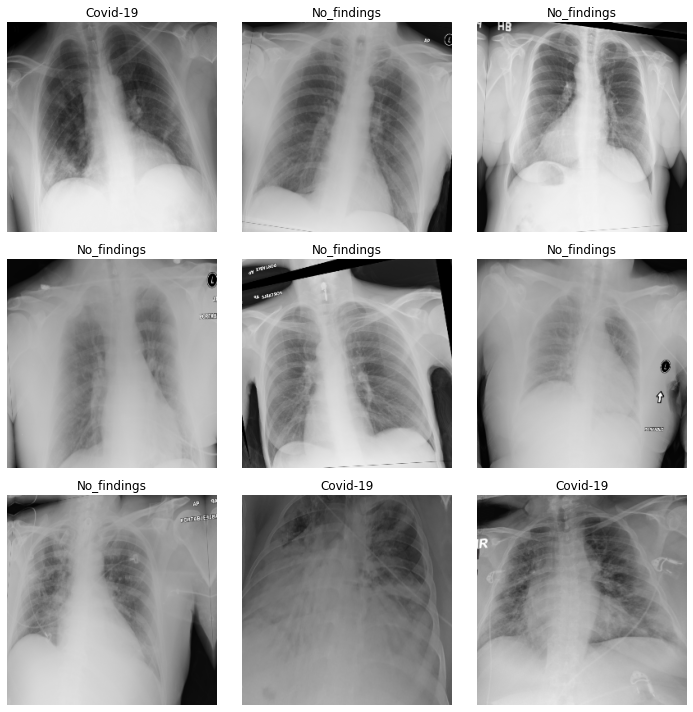

In [11]:
#Sample images from the dataset
data.show_batch(rows=3, figsize=(10,10))

## DarkCovidNet (modified Darknet model)

In [12]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [13]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [14]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [15]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 2),
    Flatten(),
    nn.Linear(338, 2)
)

In [16]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [17]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [18]:
learn.fit_one_cycle(50, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.434243,0.805444,0.152000,00:29
1,0.323917,0.776005,0.160000,00:30
2,0.262562,0.194629,0.944000,00:29
3,0.229505,0.229634,0.928000,00:30
4,0.208446,0.164779,0.952000,00:29
5,0.189873,0.351720,0.928000,00:29
6,0.187638,0.114961,0.952000,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.434243,0.805444,0.152000,00:29
1,0.323917,0.776005,0.160000,00:30
2,0.262562,0.194629,0.944000,00:29
3,0.229505,0.229634,0.928000,00:30
4,0.208446,0.164779,0.952000,00:29
5,0.189873,0.351720,0.928000,00:29
6,0.187638,0.114961,0.952000,00:30
7,0.191123,0.215209,0.912000,00:30
8,0.202739,0.336183,0.928000,00:29
9,0.201186,0.582667,0.904000,00:29


In [19]:
learn.export()

In [81]:
# Predict for single image
model_export = load_learner("/content/drive/MyDrive/COVID-19/X-Ray Image DataSet")

img_cv2 = cv2.imread('/content/drive/MyDrive/COVID-19/X-Ray Image DataSet/Covid-19/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg')
img_fastai = Image(pil2tensor(img_cv2, dtype=np.float32).div_(255))
model_export.predict(img_fastai)[0].obj

'Covid-19'

In [66]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

In [67]:
accuracy(probs,targets)

tensor(0.9920)

In [82]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings']
print(classification_report(y_true1, y_pred1, target_names=target_names))

125 124 0.992
[[ 18   1]
 [  0 106]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.95      0.97        19
 No_findings       0.99      1.00      1.00       106

    accuracy                           0.99       125
   macro avg       1.00      0.97      0.98       125
weighted avg       0.99      0.99      0.99       125



In [83]:
interp = ClassificationInterpretation.from_learner(learn)

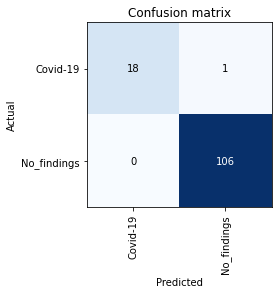

In [84]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);